<a href="https://colab.research.google.com/github/ditsa28/colab_-proj/blob/main/Brain_Tumor1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys
import os
from pathlib import Path

def count_files(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

directory_path = '/content/drive/MyDrive/brain_tumor_dataset/yes' # Removed the '/*.jpg' since os.listdir expects a directory
print(f'Number of files: {count_files(directory_path)}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of files: 155


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

directory_path = '/content/drive/MyDrive/brain_tumor_dataset/no' # Removed the '/*.jpg' since os.listdir expects a directory
print(f'Number of files: {count_files(directory_path)}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of files: 98


In [ ]:
import cv2
from pathlib import Path

# List to store images
tumor = []

# Define the directory path
directory_path = Path("/content/drive/MyDrive/brain_tumor_dataset/yes")

# Counters for total files and corrupted files
total_files = 0
corrupted_files = 0

# Iterate through all jpg files in the directory
for file_path in directory_path.glob("*.jpg"):
    if not file_path.name.startswith('.'):
        total_files += 1  # Increment the total files counter
        # Read the image
        img = cv2.imread(str(file_path))

        if img is not None:
            # Resize the image
            img = cv2.resize(img, (128, 128))

            # Split the image into its color channels
            b, g, r = cv2.split(img)

            # Merge the channels back in RGB order
            img = cv2.merge([r, g, b])

            # Append the processed image to the list
            tumor.append(img)
        else:
            corrupted_files += 1  # Increment the corrupted files counter
            print(f"Warning: Unable to read image {file_path}")
    else:
        print(f"Skipping hidden file: {file_path}")

# Print the total number of images processed and other statistics
print(f"Number of images processed: {len(tumor)}")
print(f"Number of corrupted or unreadable files: {corrupted_files}")
print(f"Expected number of images: 155")
print(f"Missing images: {155 - len(tumor) - corrupted_files}")
print(f"Total files found: {total_files}")


Number of images processed: 86
Number of corrupted or unreadable files: 0
Expected number of images: 155
Missing images: 69
Total files found: 86


In [ ]:
len(tumor)

86

In [ ]:
import cv2
from pathlib import Path
healthy = []

# Define the directory path
directory_path = Path("/content/drive/MyDrive/brain_tumor_dataset/no")

# Counters for total files and corrupted files
total_files = 0
corrupted_files = 0

# Iterate through all jpg files in the directory
for file_path in directory_path.glob("*.jpg"):
    if not file_path.name.startswith('.'):
        total_files += 1  # Increment the total files counter
        # Read the image
        img = cv2.imread(str(file_path))

        if img is not None:
            # Resize the image
            img = cv2.resize(img, (128, 128))

            # Split the image into its color channels
            b, g, r = cv2.split(img)

            # Merge the channels back in RGB order
            img = cv2.merge([r, g, b])

            # Append the processed image to the list
            healthy.append(img)
        else:
            corrupted_files += 1  # Increment the corrupted files counter
            print(f"Warning: Unable to read image {file_path}")
    else:
        print(f"Skipping hidden file: {file_path}")

# Print the total number of images processed and other statistics
print(f"Number of images processed: {len(healthy)}")
print(f"Number of corrupted or unreadable files: {corrupted_files}")
print(f"Expected number of images: 98")
print(f"Missing images: { 98- len(healthy) - corrupted_files}")
print(f"Total files found: {total_files}")


Number of images processed: 85
Number of corrupted or unreadable files: 0
Expected number of images: 98
Missing images: 13
Total files found: 85


In [ ]:
len(healthy)

85

In [ ]:
healthy = np.array(healthy)
tumor = np.array(tumor)
All = np.concatenate((healthy, tumor))

In [ ]:
All.shape

(171, 128, 128, 3)

In [ ]:
healthy.shape

(85, 128, 128, 3)

In [ ]:
tumor.shape

(86, 128, 128, 3)

In [ ]:
np.random.choice(10, 5, replace=False)

array([6, 2, 8, 3, 0])

# **VISUALIZE MRI IMAGES**

In [ ]:

def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])

    plt.figure(figsize=(16,9))
    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])

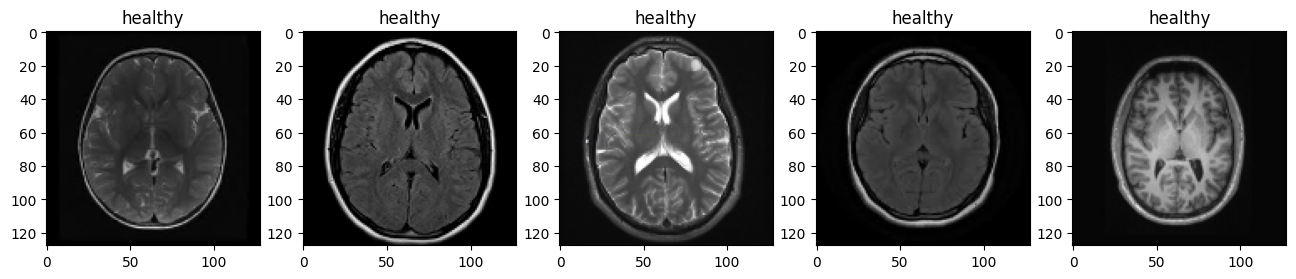

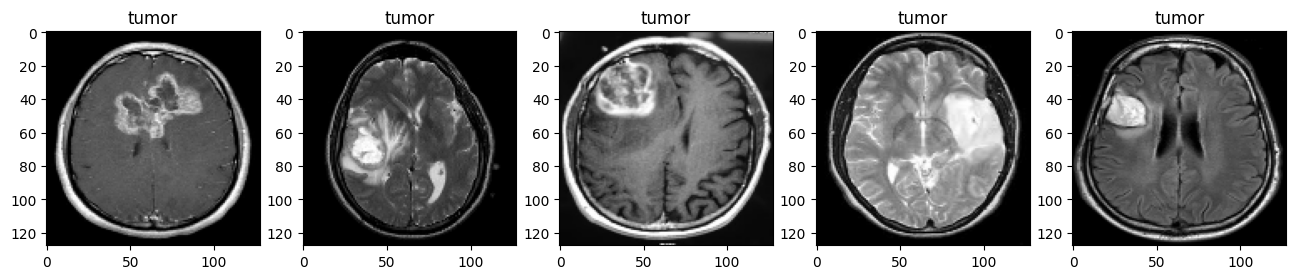

In [ ]:
plot_random(healthy, tumor, num=5)

# **Create Torch Dataset Class**

In [ ]:
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])

# **Creating MRI custom dataset class**

In [ ]:
class MRI(Dataset):
    def __init__(self):

        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("/content/drive/MyDrive/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("/content/drive/MyDrive/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)

        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):

        sample = {'image': self.images[index], 'label':self.labels[index]}

        return sample

    def normalize(self):
        self.images = self.images/255.0
mri_dataset = MRI()
mri_dataset.normalize()
print(len(mri_dataset))

171


# **Creating a data loader**

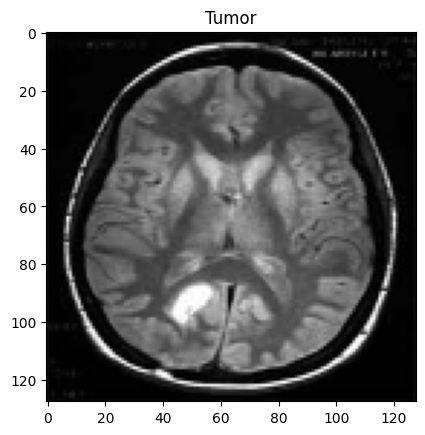

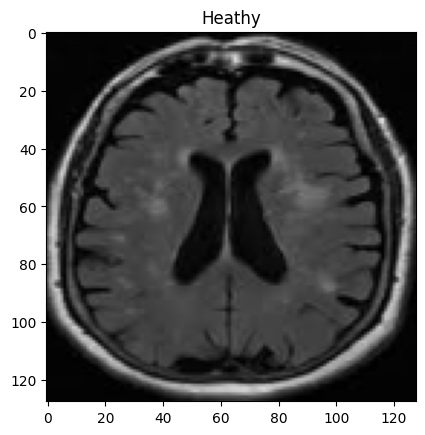

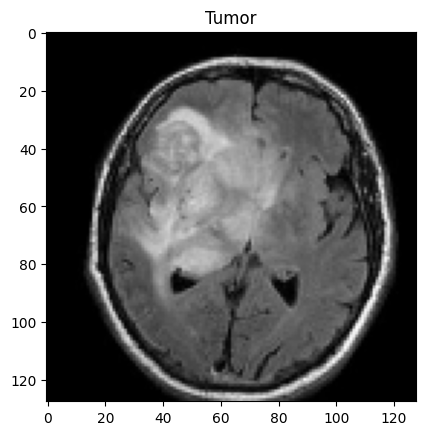

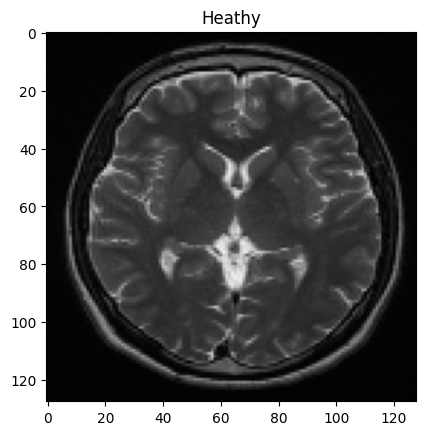

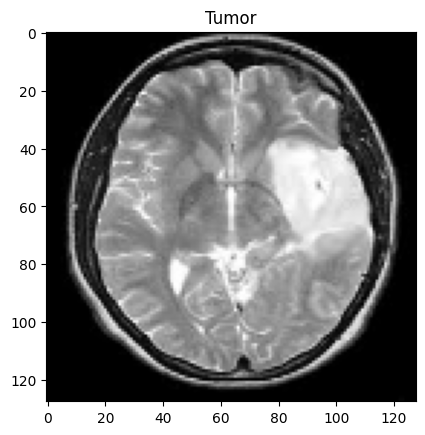

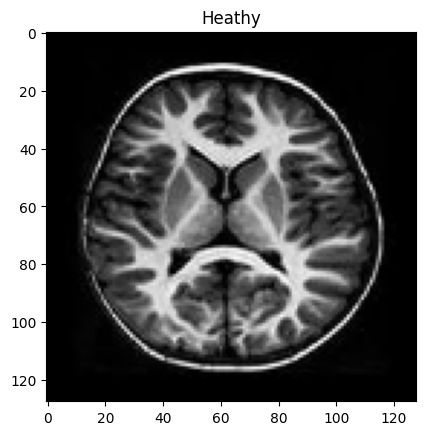

In [ ]:
# One way of iterating
names={0:'Heathy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 5:
        break

# **Create a Model**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))

        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))

    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)

        return x

# **Evaluate a New-Born Neural Network!**

In [ ]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.5950, 0.7327, 0.6387, 0.2333, 0.9329, 0.7722, 0.5996, 0.8670, 0.7517,
        0.9859]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.5950, 0.7327, 0.6387, 0.2333, 0.9329, 0.7722, 0.5996, 0.8670, 0.7517,
        0.9859]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.3540, 0.5369, 0.4079, 0.0544, 0.8703, 0.5963, 0.3595, 0.7517, 0.5651,
        0.9721])


In [ ]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cpu') # Change device to 'cpu'
model = CNN().to(device)

In [ ]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)


In [ ]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())


In [ ]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [ ]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [ ]:
accuracy_score(y_true, threshold(outputs))

0.49707602339181284

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

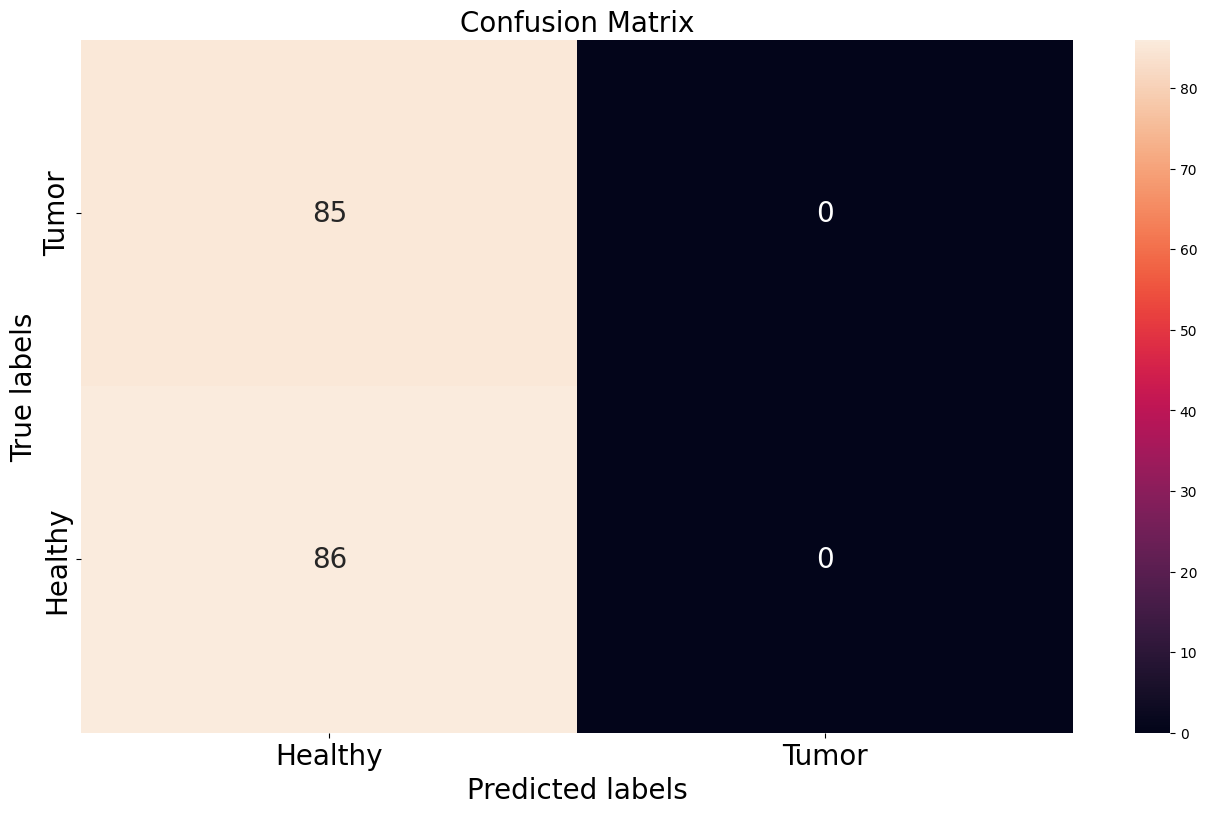

In [ ]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

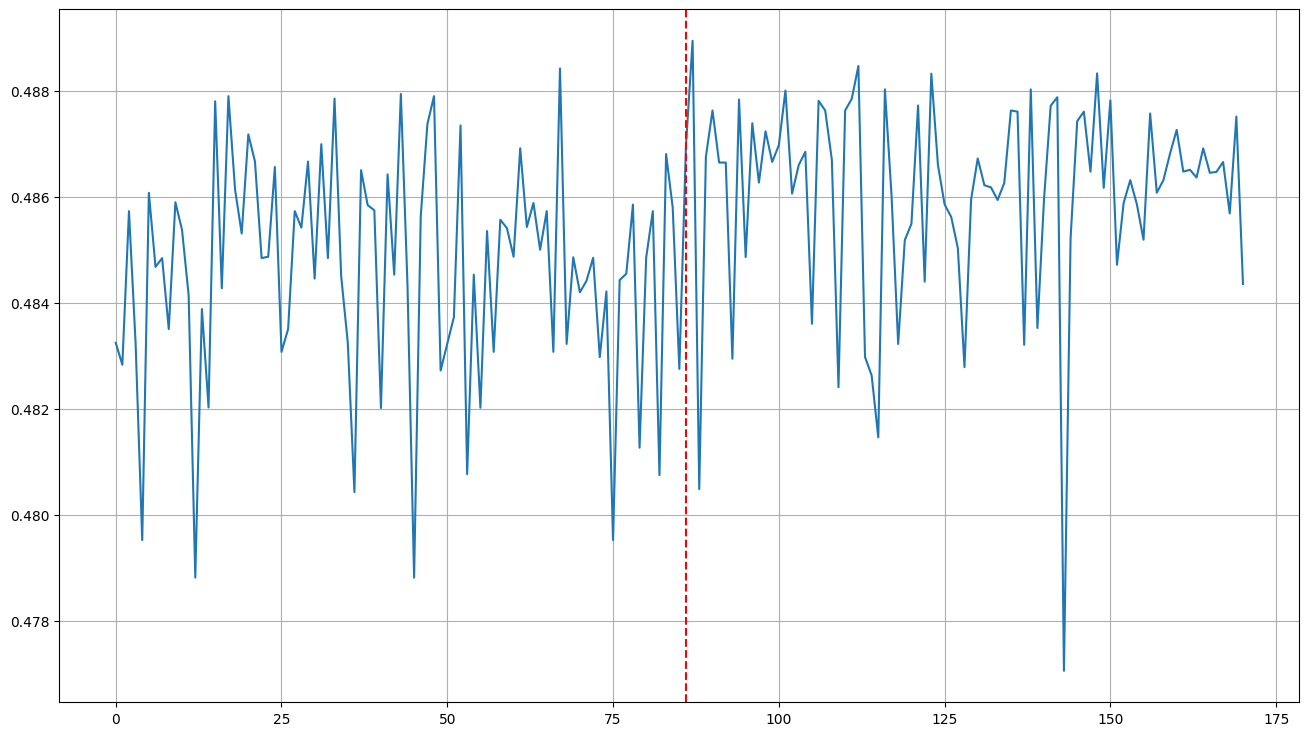

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()


# **Train the Dumb Model**

In [ ]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [ ]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.668703
Train Epoch: 20	Loss: 0.628402
Train Epoch: 30	Loss: 0.583650
Train Epoch: 40	Loss: 0.556724
Train Epoch: 50	Loss: 0.546505
Train Epoch: 60	Loss: 0.516283
Train Epoch: 70	Loss: 0.495745
Train Epoch: 80	Loss: 0.466019
Train Epoch: 90	Loss: 0.408456
Train Epoch: 100	Loss: 0.401649
Train Epoch: 110	Loss: 0.343082
Train Epoch: 120	Loss: 0.347607
Train Epoch: 130	Loss: 0.289947
Train Epoch: 140	Loss: 0.302607
Train Epoch: 150	Loss: 0.265641
Train Epoch: 160	Loss: 0.232679
Train Epoch: 170	Loss: 0.200909
Train Epoch: 180	Loss: 0.169957
Train Epoch: 190	Loss: 0.151899
Train Epoch: 200	Loss: 0.137141
Train Epoch: 210	Loss: 0.116367
Train Epoch: 220	Loss: 0.102098
Train Epoch: 230	Loss: 0.070232
Train Epoch: 240	Loss: 0.065968
Train Epoch: 250	Loss: 0.052640
Train Epoch: 260	Loss: 0.044379
Train Epoch: 270	Loss: 0.037118
Train Epoch: 280	Loss: 0.028520
Train Epoch: 290	Loss: 0.021603
Train Epoch: 300	Loss: 0.019377
Train Epoch: 310	Loss: 0.016815
Train Epoch: 320	

# **Evaluate a smart model**

In [ ]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [ ]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

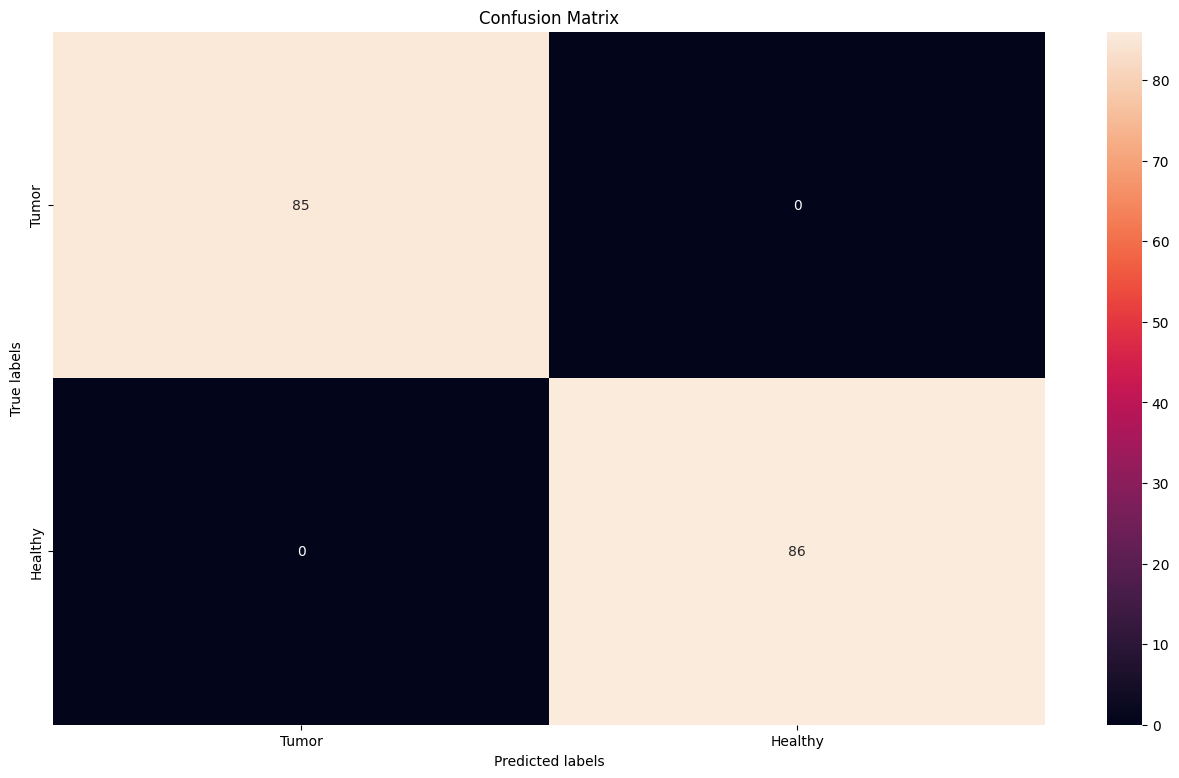

In [ ]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

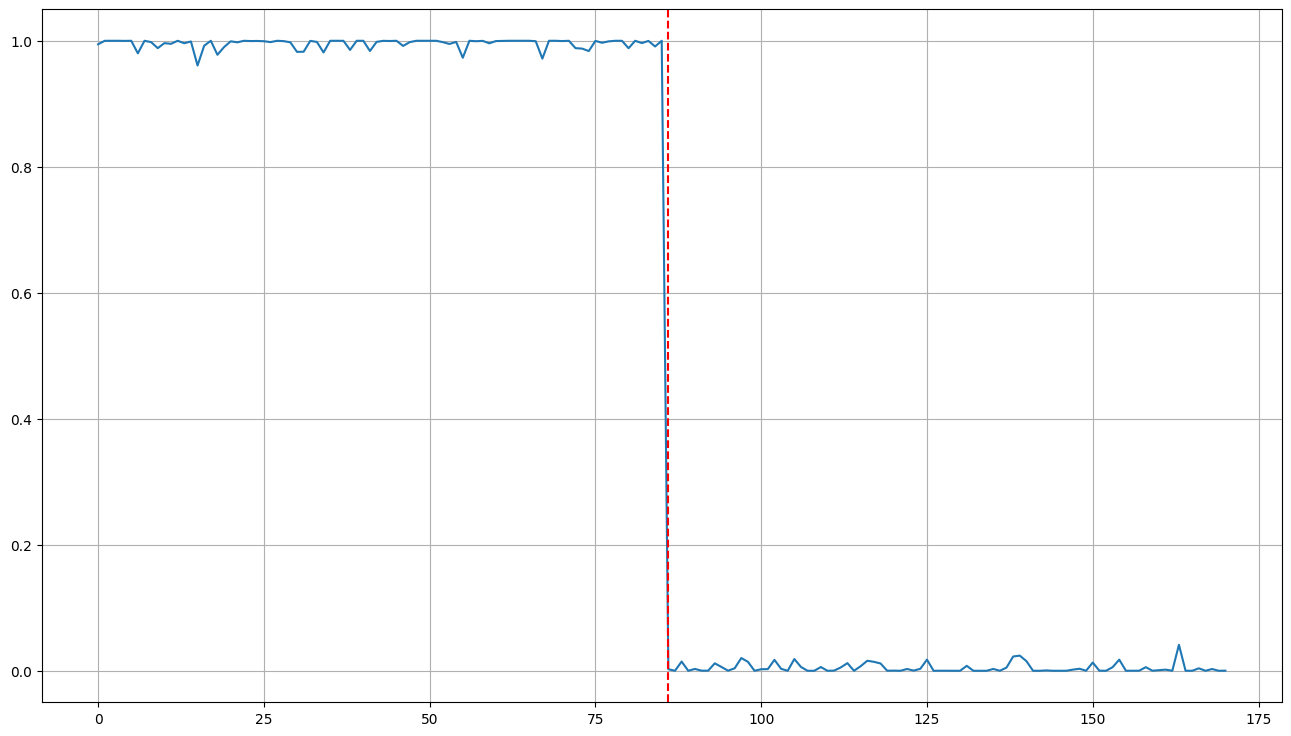

In [ ]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

# **Visualising the Feature Maps of the Convolutional Filters**

In [ ]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [ ]:
no_of_layers = 0
conv_layers = []

In [ ]:
model_children = list(model.children())
model_children


[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [ ]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [ ]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

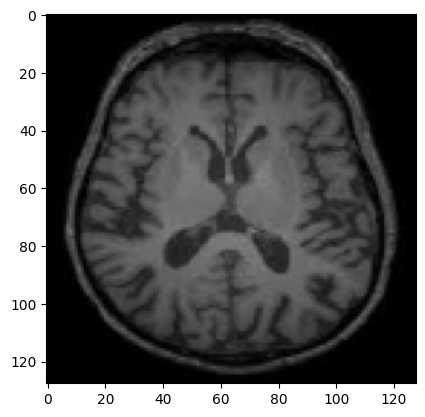

In [ ]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [ ]:
img = torch.from_numpy(img).to(device)

In [ ]:
img.shape

torch.Size([3, 128, 128])

In [ ]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [ ]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


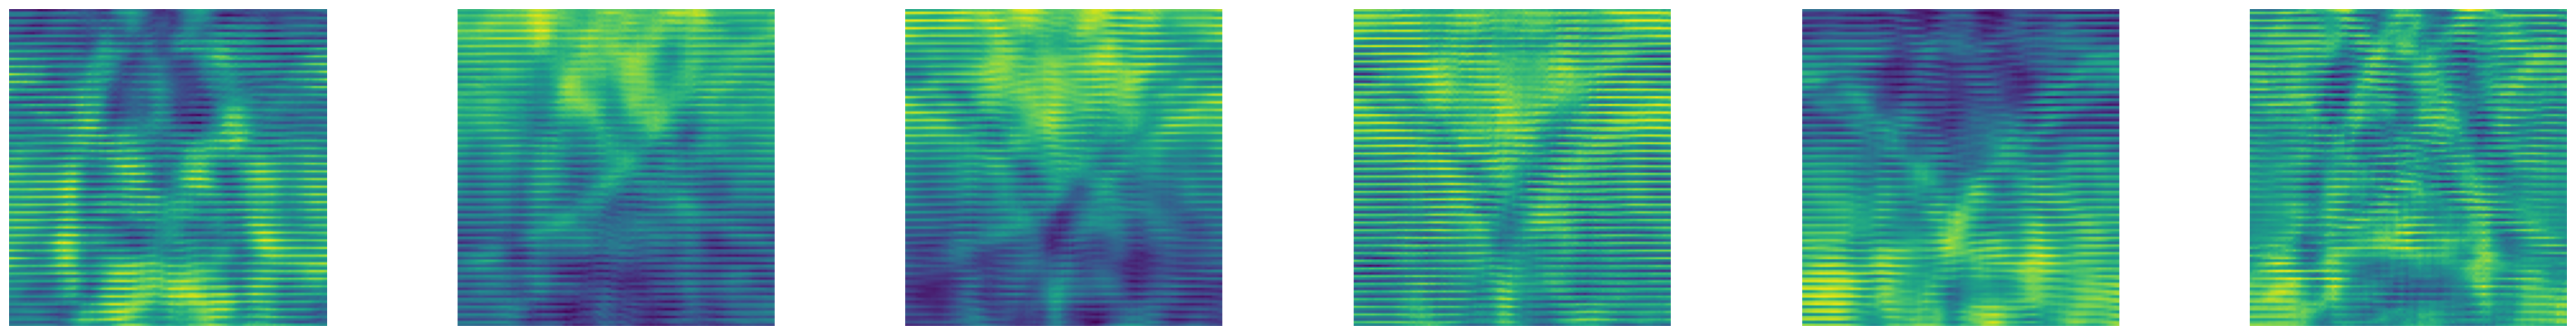

Layer  2


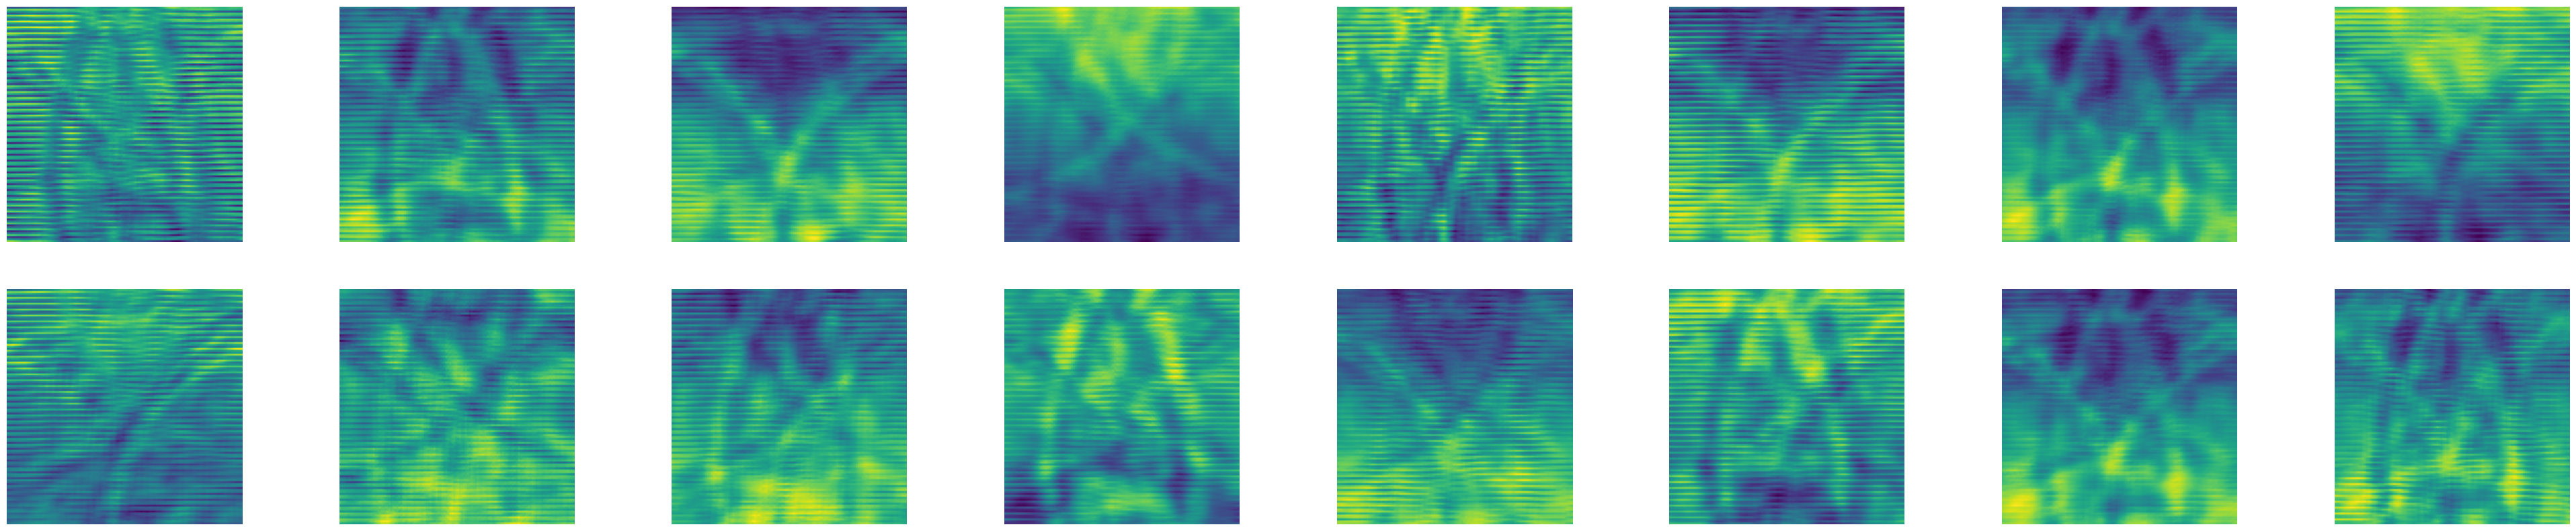

In [ ]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

# **Are We Over-fitting?**
# Preparing a validation set: We need to change the MRI dataset slightly!

We will need to make changes to our MRI dataset class:

**1.**Define a function to divide the data into train and validation sets

**2.**Define a variable called mode to determine whether we are interested in the training OR validation data

**3.**Change len() and getitem() functions and conditioned over the variable mode

In [ ]:
from sklearn.model_selection import train_test_split
class MRI(Dataset):

    def __init__(self):

        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None

        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'

        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./data/brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./data/brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)

        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)

        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)

    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]

    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}

        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}

        return sample

    def normalize(self):
        self.images = self.images/255.0